##### Emily Ahn 69064335
##### Yimeng Liu 23833957

# Stock Data Visualization and Stock Market Forecasting

## Introduction

!!! INTRO

### Required packages

### uncomment and run below if altair not installed

In [1]:
# import sys
# !{sys.executable} -m pip install altair

In [2]:
!pip install pmdarima

  Using cached pmdarima-2.0.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (1.8 MB)


In [33]:
import pandas as pd
import numpy as np
import altair as alt
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# import datetime as dt
# from datetime import datetime    
# sns.set_style("whitegrid")
# from pandas.plotting import autocorrelation_plot
# plt.style.use("ggplot")
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf as acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
# from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_squared_error

### Loading required dataset

In [4]:
# Amazon
amzn = pd.read_csv('data/AMZN.csv').iloc[3684:]
# Apple
aapl = pd.read_csv('data/AAPL.csv').iloc[7836:]
# Microsft
msft = pd.read_csv('data/MSFT.csv').iloc[6510:]

## Exploratory Data Analysis

In [5]:
amzn.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
3684,04-01-2012,8.8035,8.9605,84104000,9.0250,8.8755,8.8755
3685,05-01-2012,8.7025,8.7970,76182000,8.9125,8.8805,8.8805
3686,06-01-2012,8.8750,8.9035,140168000,9.2325,9.1305,9.1305
3687,09-01-2012,8.8500,9.1380,101138000,9.2185,8.9280,8.9280
3688,10-01-2012,8.8550,9.0550,79716000,9.1200,8.9670,8.9670


In [6]:
aapl.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
7836,04-01-2012,14.617143,14.642857,260022000,14.810000,14.765714,12.586558
7837,05-01-2012,14.738214,14.819643,271269600,14.948214,14.929643,12.726295
7838,06-01-2012,14.972143,14.991786,318292800,15.098214,15.085714,12.859331
7839,09-01-2012,15.048214,15.196429,394024400,15.276786,15.061786,12.838937
7840,10-01-2012,15.053571,15.211071,258196400,15.214286,15.115714,12.884903


In [7]:
msft.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
6510,04-01-2012,26.780001,26.820000,80516100,27.469999,27.400000,22.260885
6511,05-01-2012,27.290001,27.379999,56081400,27.730000,27.680000,22.488358
6512,06-01-2012,27.530001,27.530001,99455500,28.190001,28.110001,22.837715
6513,09-01-2012,27.719999,28.049999,59706800,28.100000,27.740000,22.537107
6514,10-01-2012,27.750000,27.930000,60014400,28.150000,27.840000,22.618357


In [8]:
# amazon average monthly open value list
amazon_monthly_open = amzn.groupby(pd.PeriodIndex(amzn['Date'], freq="M"))['Open'].mean().reset_index()

amazon_monthly_open['Date'] = amazon_monthly_open['Date'].apply(lambda x: x.to_timestamp())

# apple average monthly open value list
apple_monthly_open = aapl.groupby(pd.PeriodIndex(aapl['Date'], freq="M"))['Open'].mean().reset_index()

apple_monthly_open['Date'] = apple_monthly_open['Date'].apply(lambda x: x.to_timestamp())

# microsoft average monthly open value list
microsoft_monthly_open = msft.groupby(pd.PeriodIndex(msft['Date'], freq="M"))['Open'].mean().reset_index()

microsoft_monthly_open['Date'] = microsoft_monthly_open['Date'].apply(lambda x: x.to_timestamp())

# create company comlumn that shows where the data is from
amazon_monthly_open['company']= 'amzn'
apple_monthly_open['company']= 'aapl'
microsoft_monthly_open['company']= 'msft'

opens = [amazon_monthly_open, apple_monthly_open, microsoft_monthly_open]

# concat all companes into one df
open_top3_nasdaq = pd.concat(opens)

open_top3_nasdaq.head()

/tmp/ipykernel_59/2226228315.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  amazon_monthly_open = amzn.groupby(pd.PeriodIndex(amzn['Date'], freq="M"))['Open'].mean().reset_index()
/tmp/ipykernel_59/2226228315.py:7: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  apple_monthly_open = aapl.groupby(pd.PeriodIndex(aapl['Date'], freq="M"))['Open'].mean().reset_index()
/tmp/ipykernel_59/2226228315.py:12: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  microsoft_monthly_open = msft.groupby(pd.PeriodIndex(msft['Date'], freq="M"))['Open'].mean().reset_index()


,Date,Open,company
0,2012-01-01,9.914868,amzn
1,2012-02-01,9.808325,amzn
2,2012-03-01,10.158310,amzn
3,2012-04-01,10.309158,amzn
4,2012-05-01,10.956250,amzn


In [9]:
# amazon average monthly closing value list
amazon_monthly_close = amzn.groupby(pd.PeriodIndex(amzn['Date'], freq="M"))['Close'].mean().reset_index()

amazon_monthly_close['Date'] = amazon_monthly_close['Date'].apply(lambda x: x.to_timestamp())

# apple average monthly closing value list
apple_monthly_close = aapl.groupby(pd.PeriodIndex(aapl['Date'], freq="M"))['Close'].mean().reset_index()

apple_monthly_close['Date'] = apple_monthly_close['Date'].apply(lambda x: x.to_timestamp())

# microsoft average monthly closing value list
microsoft_monthly_close = msft.groupby(pd.PeriodIndex(msft['Date'], freq="M"))['Close'].mean().reset_index()

microsoft_monthly_close['Date'] = microsoft_monthly_close['Date'].apply(lambda x: x.to_timestamp())

# create company comlumn that shows where the data is from
amazon_monthly_close['company']= 'amzn'
apple_monthly_close['company']= 'aapl'
microsoft_monthly_close['company']= 'msft'

closings = [amazon_monthly_close, apple_monthly_close, microsoft_monthly_close]

# concat all companes into one df
close_top3_nasdaq = pd.concat(closings)

close_top3_nasdaq.head()

/tmp/ipykernel_59/954031980.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  amazon_monthly_close = amzn.groupby(pd.PeriodIndex(amzn['Date'], freq="M"))['Close'].mean().reset_index()
/tmp/ipykernel_59/954031980.py:7: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  apple_monthly_close = aapl.groupby(pd.PeriodIndex(aapl['Date'], freq="M"))['Close'].mean().reset_index()
/tmp/ipykernel_59/954031980.py:12: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  microsoft_monthly_close = msft.groupby(pd.PeriodIndex(msft['Date'], freq="M"))['Close'].mean().reset_index()


,Date,Close,company
0,2012-01-01,9.960711,amzn
1,2012-02-01,9.812850,amzn
2,2012-03-01,10.232095,amzn
3,2012-04-01,10.350342,amzn
4,2012-05-01,10.920182,amzn


In [10]:
# amazon average monthly volumn
amazon_monthly_volume = amzn.groupby(pd.PeriodIndex(amzn['Date'], freq="M"))['Volume'].mean().reset_index()

amazon_monthly_volume['Date'] = amazon_monthly_volume['Date'].apply(lambda x: x.to_timestamp())

# apple average monthly volumn
apple_monthly_volume = aapl.groupby(pd.PeriodIndex(aapl['Date'], freq="M"))['Volume'].mean().reset_index()

apple_monthly_volume['Date'] = apple_monthly_volume['Date'].apply(lambda x: x.to_timestamp())

# microsoft average monthly volumn
microsoft_monthly_volume = msft.groupby(pd.PeriodIndex(msft['Date'], freq="M"))['Volume'].mean().reset_index()

microsoft_monthly_volume['Date'] = microsoft_monthly_volume['Date'].apply(lambda x: x.to_timestamp())

# create company comlumn that shows where the data is from
amazon_monthly_volume['company']= 'amzn'
apple_monthly_volume['company']= 'aapl'
microsoft_monthly_volume['company']= 'msft'

volume = [amazon_monthly_volume, apple_monthly_volume, microsoft_monthly_volume]

# concat all companes into one df
volume_top3_nasdaq = pd.concat(volume)

volume_top3_nasdaq.head()

/tmp/ipykernel_59/681992908.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  amazon_monthly_volume = amzn.groupby(pd.PeriodIndex(amzn['Date'], freq="M"))['Volume'].mean().reset_index()
/tmp/ipykernel_59/681992908.py:7: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  apple_monthly_volume = aapl.groupby(pd.PeriodIndex(aapl['Date'], freq="M"))['Volume'].mean().reset_index()
/tmp/ipykernel_59/681992908.py:12: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  microsoft_monthly_volume = msft.groupby(pd.PeriodIndex(msft['Date'], freq="M"))['Volume'].mean().reset_ind

,Date,Volume,company
0,2012-01-01,1.251382e+08,amzn
1,2012-02-01,1.138773e+08,amzn
2,2012-03-01,9.989057e+07,amzn
3,2012-04-01,1.081960e+08,amzn
4,2012-05-01,7.317045e+07,amzn


### Plots

### Opening prices by companies

In [11]:
# selection interaction
nearest = alt.selection_single(nearest=True, on='mouseover')

# stock average monthly open value 
monthly_open_plt = alt.Chart(open_top3_nasdaq).mark_line(interpolate='basis').encode(
    alt.X('Date:T'),
    alt.Y('Open:Q', type='quantitative'),
    color='company:N'
)

# select chart
selectors = alt.Chart(open_top3_nasdaq).mark_point().encode(
    alt.X('Date:T'),
    opacity=alt.value(0),
).add_selection (
    nearest
)

# Draw points on the line, and highlight based on selection
points = monthly_open_plt.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = monthly_open_plt.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Open:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(open_top3_nasdaq).mark_rule(color='gray').encode(
    alt.X('Date:T'),
).transform_filter(
    nearest
)
                         
# 

# Put the five layers into a chart and bind the data
alt.layer(
    monthly_open_plt, selectors, points, rules, text
).properties(
    width=600
).interactive(
)

alt.LayerChart(...)

### Closing prices by companies

In [12]:
# selection interaction
nearest = alt.selection_single(nearest=True, on='mouseover')

# stock average monthly open value 
monthly_close_plt = alt.Chart(close_top3_nasdaq).mark_line(interpolate='basis').encode(
    alt.X('Date:T'),
    alt.Y('Close:Q', type='quantitative'),
    color='company:N'
)

# select chart
selectors = alt.Chart(close_top3_nasdaq).mark_point().encode(
    alt.X('Date:T'),
    opacity=alt.value(0),
).add_selection (
    nearest
)

# Draw points on the line, and highlight based on selection
points = monthly_close_plt.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = monthly_close_plt.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Close:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(close_top3_nasdaq).mark_rule(color='gray').encode(
    alt.X('Date:T'),
).transform_filter(
    nearest
)
                         
# 

# Put the five layers into a chart and bind the data
alt.layer(
    monthly_close_plt, selectors, points, rules, text
).properties(
    width=600
).interactive(
)

alt.LayerChart(...)

### Volumn prices by companies

In [13]:
# selection interaction
nearest = alt.selection_single(nearest=True, on='mouseover')

# stock average monthly open value 
monthly_volume_plt = alt.Chart(volume_top3_nasdaq).mark_line(interpolate='basis').encode(
    alt.X('Date:T'),
    alt.Y('Volume:Q', type='quantitative'),
    color='company:N'
)

# select chart
selectors = alt.Chart(volume_top3_nasdaq).mark_point().encode(
    alt.X('Date:T'),
    opacity=alt.value(0),
).add_selection (
    nearest
)

# point 
points = monthly_volume_plt.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# text
text = monthly_volume_plt.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Volume:Q', alt.value(' '))
)

# ruling
rules = alt.Chart(volume_top3_nasdaq).mark_rule(color='gray').encode(
    alt.X('Date:T'),
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
alt.layer(
    monthly_volume_plt, selectors, points, rules, text
).properties(
    width=600
).interactive(
)

alt.LayerChart(...)

Correlation graph

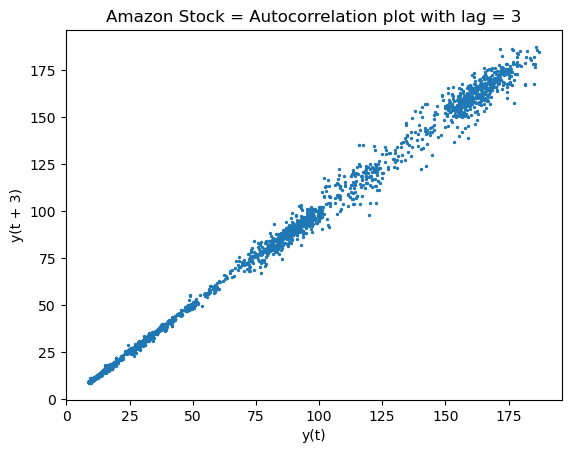

In [14]:
plt.figure()
lag_plot(amzn['Open'], lag=3, s = 2)
plt.title('Amazon Stock = Autocorrelation plot with lag = 3')
plt.show()

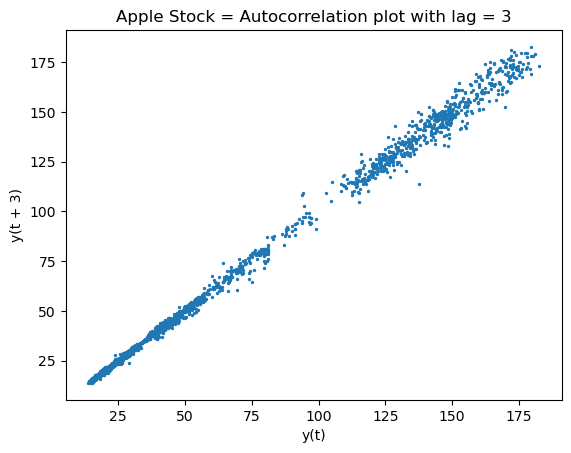

In [15]:
plt.figure()
lag_plot(aapl['Open'], lag=3, s = 2)
plt.title('Apple Stock = Autocorrelation plot with lag = 3')
plt.show()

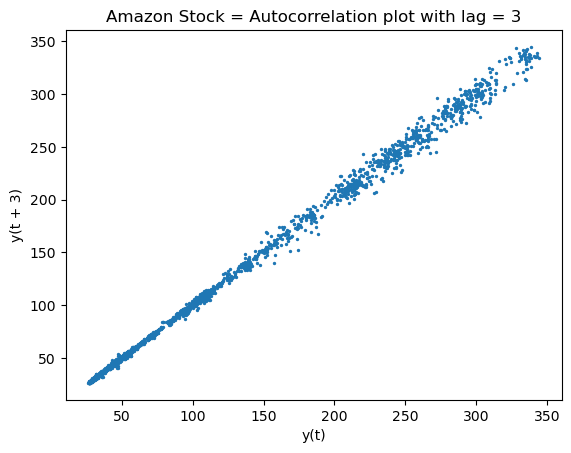

In [16]:
plt.figure()
lag_plot(msft['Open'], lag=3, s = 2)
plt.title('Amazon Stock = Autocorrelation plot with lag = 3')
plt.show()

##### Seeing the above lag plots show that there  is a linear pattern and ARIMA will be a suited model

## ARIMA Model Construction
### Introduction
ARIMA stands for Auto Regressive Integrated Moving Average. It is a statistical analysis model that uses time series data to either better understand the dataset or to predict future trends. An autoregressive statistical model predicts future values based on past values. The ARIMA model is considered as a efficient, reliable technique and has been widely utilized in many fields, such as banking and economics. In our project, we are going to using ARIMA model to seek to predict a stock's future prices based on its past performance.

To construct an ARIMA model, all we need is to find three parameters, p, d, q.
* p: 
### Prepare data
In our project, we decided to focus on the Closing price of each stock and make predictions of it using Time Series with ARIMA model. To get prepared for it, we first need to construct training data and testing data. We started by converting daily data into the mean of weekly data, which reduced the amount of data to make the process more efficient. Then, we divided the data into training data, which is from 2012 to 2021, and the rest to be testing data. The ratio of training data and testing data is about 8:2. Moreover, as there are great fluctuations in stock market prices, to reduce the magnitude of the values and the growing trend in the series, we took a log of the series.

In [17]:
# split train and test data
amzn1 = pd.read_csv('data/AMZN.csv',index_col=0,parse_dates=[0]).iloc[3684:]
aapl1 = pd.read_csv('data/AAPL.csv',index_col=0,parse_dates=[0]).iloc[7836:]
msft1 = pd.read_csv('data/MSFT.csv',index_col=0,parse_dates=[0]).iloc[6510:]

amzn_week = amzn1['Close'].resample('W-MON').mean()
aapl_week = aapl1['Close'].resample('W-MON').mean()
msft_week = msft1['Close'].resample('W-MON').mean()

amzn_train=np.log(amzn_week['2012':'2021'])
amzn_test=np.log(amzn_week['2021':])

aapl_train=np.log(aapl_week['2012':'2021'])
aapl_test=np.log(aapl_week['2021':])

msft_train=np.log(msft_week['2012':'2021'])
msft_test=np.log(msft_week['2021':])

/tmp/ipykernel_59/1124189719.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  amzn1 = pd.read_csv('data/AMZN.csv',index_col=0,parse_dates=[0]).iloc[3684:]
/tmp/ipykernel_59/1124189719.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  aapl1 = pd.read_csv('data/AAPL.csv',index_col=0,parse_dates=[0]).iloc[7836:]
/tmp/ipykernel_59/1124189719.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  msft1 = pd.read_csv('data/MSFT.csv',index_col=0,parse_dates=[0]).iloc[6510:]


Using Amazon data as an example, the plot shows the training data and testing data.

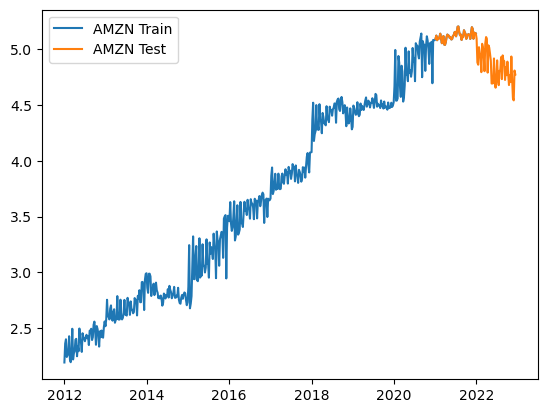

In [18]:
plt.plot(amzn_train, label='AMZN Train')
plt.plot(amzn_test, label='AMZN Test')
plt.legend()
plt.show()

### Stationary Check


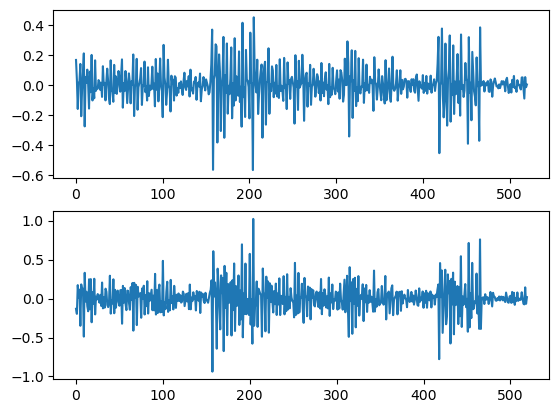

In [56]:
fig, ax = plt.subplots(2)
amzn_diff = np.diff(amzn_train)
amzn_diff2 = np.diff(np.diff(amzn_train))
ax[0].plot(amzn_diff)
ax[1].plot(amzn_diff2)

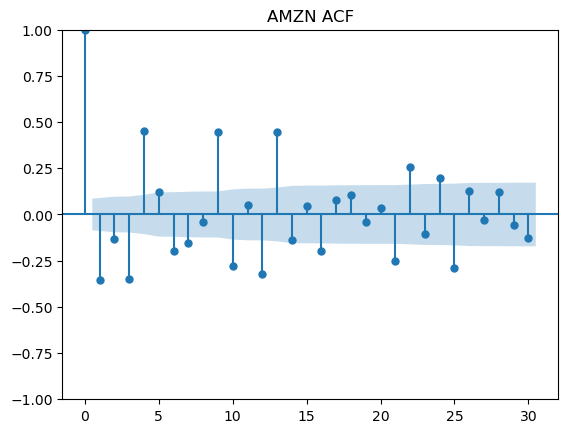

In [21]:
amzn_acf = plot_acf(amzn_diff, lags=30)
plt.title("AMZN ACF")
plt.show()

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


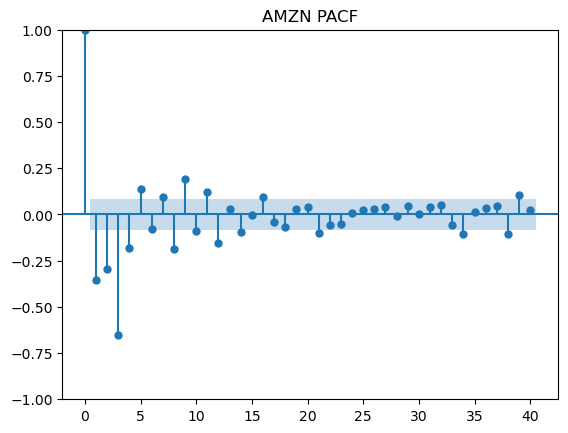

In [49]:
amzn_pacf = plot_pacf(amzn_diff, lags=40)
plt.title("AMZN PACF")
plt.show()

# assign as value as an array
amzn_train = amzn_train.values
amzn_test = amzn_test.values

aapl_train = aapl_train.values
aapl_test = aapl_test.values

msft_train = msft_train.values
msft_test = msft_test.values

In [24]:
def ad_test(dataset):
    dftest=adfuller(dataset, autolag = 'AIC')
    print("P-value: ", dftest[1])

ad_test(amzn_diff2)
#plt.figure()
#plt.plot(amzn_week1)
#test_stationarity(amzn_week1)

P-value:  6.028969077536438e-17


##### Looking at above plots we chose p = 1 and q = 1

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-689.332, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-757.374, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-916.144, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-690.257, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-915.386, Time=1.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-916.433, Time=1.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-915.635, Time=2.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-944.122, Time=2.60 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-945.625, Time=2.90 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1048.323, Time=4.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-995.036, Time=2.02 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1102.174, Time=3.89 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1101.840, Time=3.19 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-1084.993, Time=1.69 sec

Best model:  ARIMA(3,1,3)(0,

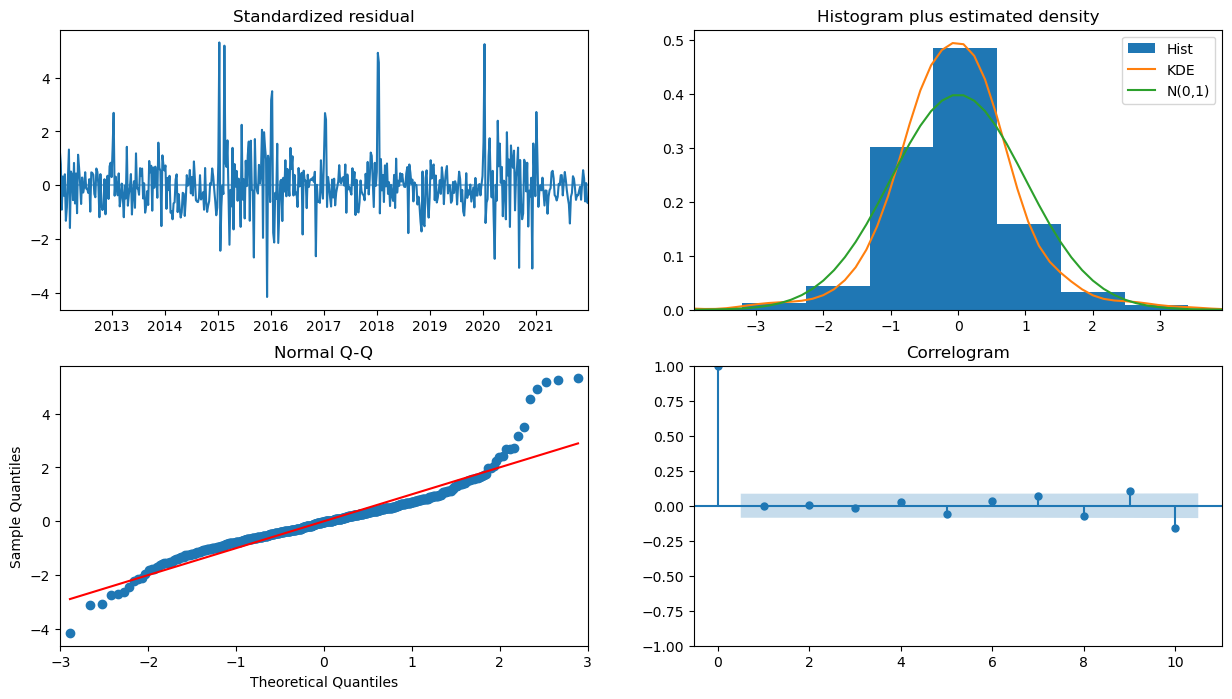

In [25]:
model_autoARIMA = auto_arima(amzn_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [26]:
amzn_model = ARIMA(amzn_train, order=(3,2,3),freq='W-MON')
amzn_fitted = amzn_model.fit()  
print(amzn_fitted.summary())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  522
Model:                 ARIMA(3, 2, 3)   Log Likelihood                 551.489
Date:                Mon, 24 Apr 2023   AIC                          -1088.977
Time:                        18:57:39   BIC                          -1059.201
Sample:                    01-02-2012   HQIC                         -1077.313
                         - 12-27-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4841      0.043    -11.284      0.000      -0.568      -0.400
ar.L2         -0.6170      0.039    -15.930      0.000      -0.693      -0.541
ar.L3         -0.6353      0.034    -18.432      0.0

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


forecast=amzn_fitted.predict(n_periods=len(amzn_test))
#forecast=pd.DataFrame(forecast,index=amzn_test.index,columns=['Prediction'])
plt.plot(amzn_train,label='Train')
plt.plot(amzn_test,label='Test')
plt.plot(forecast,label='Prediction')
plt.show()

In [27]:
amzn_pred=amzn_fitted.predict('2019','2021',dynamic=True,typ='levels')
print(amzn_pred)

Date
2019-01-07    4.414275
2019-01-14    4.424133
2019-01-21    4.351870
2019-01-28    4.325311
2019-02-04    4.391852
                ...   
2021-11-29    5.211042
2021-12-06    5.216655
2021-12-13    5.222267
2021-12-20    5.227880
2021-12-27    5.233492
Freq: W-MON, Name: predicted_mean, Length: 156, dtype: float64


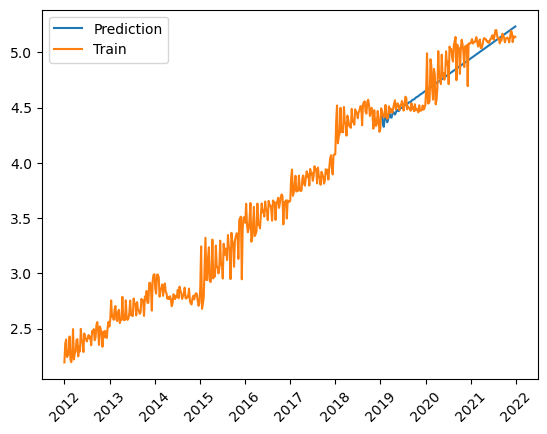

In [28]:
plt.xticks(rotation=45)
plt.plot(amzn_pred,label='Prediction')
plt.plot(amzn_train,label="Train")
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-816.546, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-874.012, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-997.285, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-817.649, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-845.640, Time=1.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1000.174, Time=0.91 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-999.220, Time=1.48 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1023.858, Time=3.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1033.559, Time=2.69 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1107.763, Time=3.91 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1086.962, Time=1.90 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1196.542, Time=3.49 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1198.542, Time=2.41 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1187.300, Time=2.09 sec
 ARIMA(2,1,1)(0,0,0)[0] i

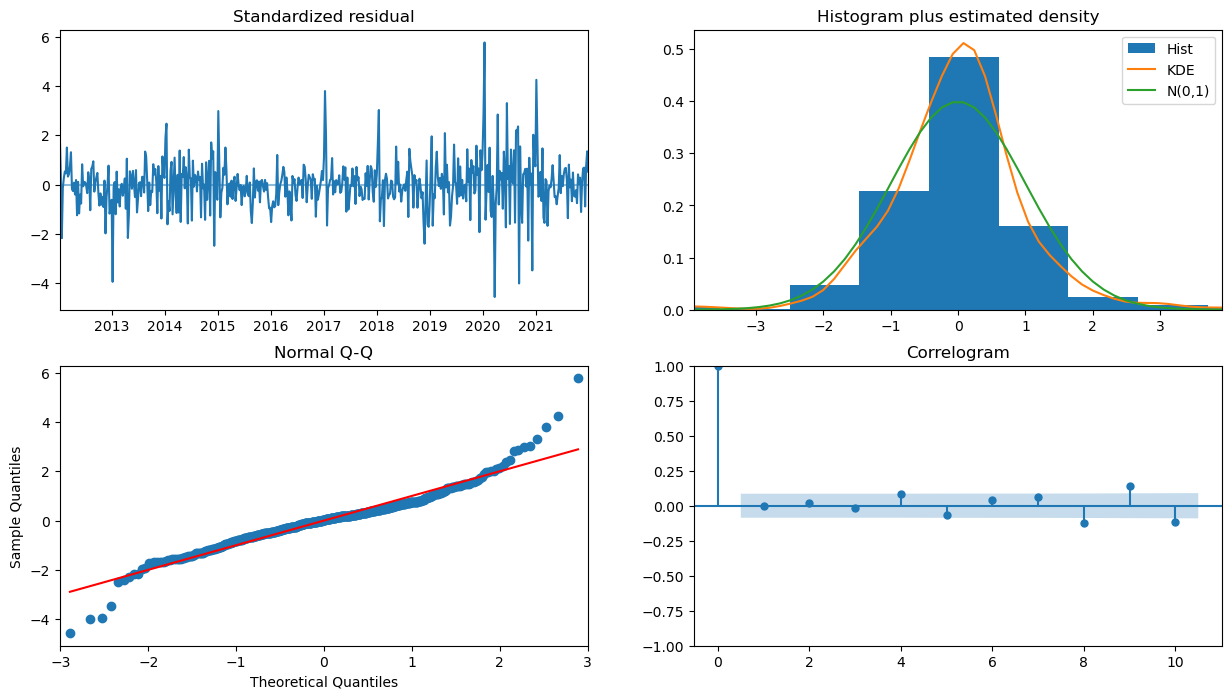

In [29]:
model_autoARIMA = auto_arima(aapl_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [251]:
aapl_model = ARIMA(aapl_train, order=(3,2,2),freq='W-MON')
aapl_fitted = aapl_model.fit()  
print(aapl_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  522
Model:                 ARIMA(3, 2, 2)   Log Likelihood                 594.329
Date:                Mon, 24 Apr 2023   AIC                          -1176.657
Time:                        08:19:29   BIC                          -1151.134
Sample:                    01-02-2012   HQIC                         -1166.659
                         - 12-27-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6131      0.039    -15.717      0.000      -0.690      -0.537
ar.L2         -0.5804      0.037    -15.797      0.000      -0.652      -0.508
ar.L3         -0.6395      0.025    -25.730      0.0

In [252]:
aapl_pred=aapl_fitted.predict('2019','2021',dynamic=True,typ='levels')
print(aapl_pred)

Date
2019-01-07    3.825729
2019-01-14    3.797181
2019-01-21    3.727020
2019-01-28    3.691926
2019-02-04    3.778078
                ...   
2021-11-29    4.049706
2021-12-06    4.051704
2021-12-13    4.053703
2021-12-20    4.055702
2021-12-27    4.057701
Freq: W-MON, Name: predicted_mean, Length: 156, dtype: float64


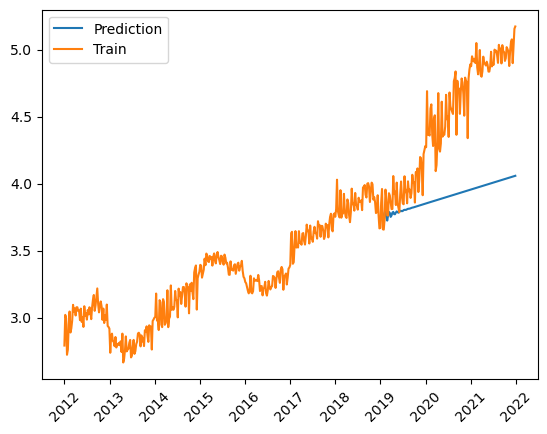

In [253]:
plt.xticks(rotation=45)
plt.plot(aapl_pred,label='Prediction')
plt.plot(aapl_train,label="Train")
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1080.740, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1140.827, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1292.312, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1081.209, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1295.678, Time=1.42 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1294.661, Time=0.90 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1314.717, Time=2.42 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1348.728, Time=3.58 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1392.634, Time=4.41 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1369.954, Time=2.60 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1493.576, Time=4.77 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1492.547, Time=2.53 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-1471.872, Time=2.08 sec

Best model:  ARIMA(3,1,3

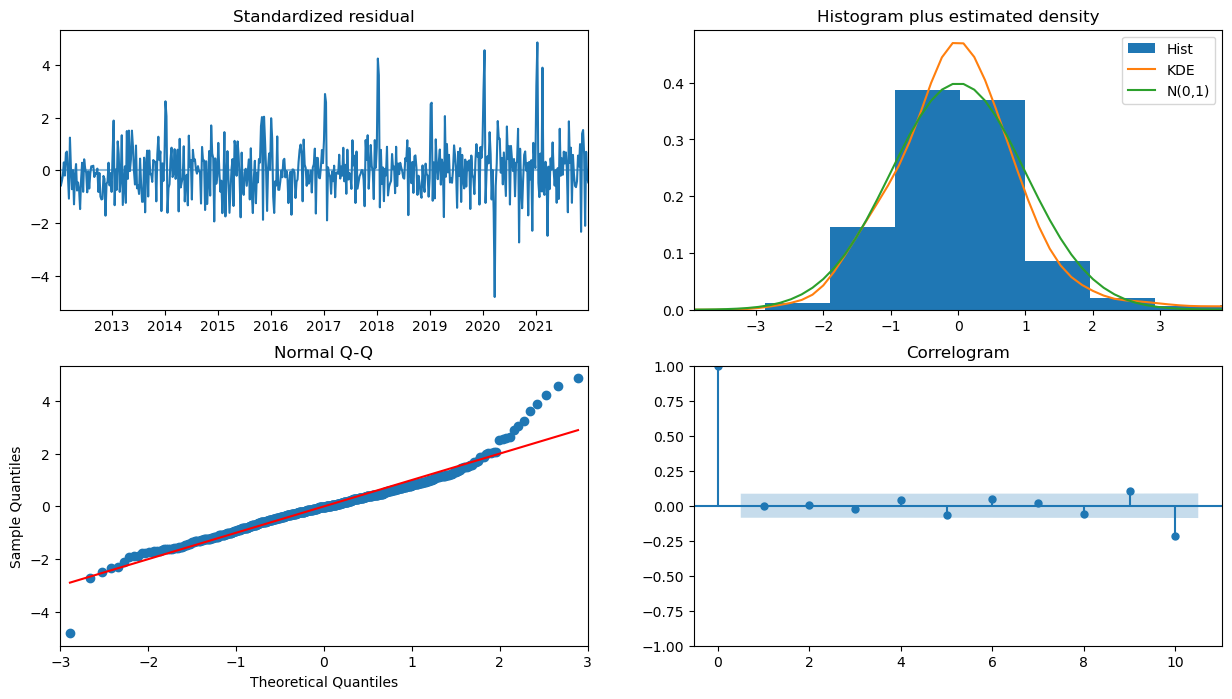

In [248]:
model_autoARIMA = auto_arima(msft_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [266]:
msft_model = ARIMA(msft_train, order=(3,2,3),freq='W-MON')
msft_fitted = msft_model.fit()  
print(msft_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  522
Model:                 ARIMA(3, 2, 3)   Log Likelihood                 745.565
Date:                Mon, 24 Apr 2023   AIC                          -1477.131
Time:                        08:23:17   BIC                          -1447.354
Sample:                    01-02-2012   HQIC                         -1465.466
                         - 12-27-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5506      0.048    -11.379      0.000      -0.645      -0.456
ar.L2         -0.6564      0.040    -16.340      0.000      -0.735      -0.578
ar.L3         -0.6739      0.035    -19.456      0.0

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [267]:
msft_pred=msft_fitted.predict('2019','2021',dynamic=True,typ='levels')
print(msft_pred)

Date
2019-01-07    4.634827
2019-01-14    4.669134
2019-01-21    4.642335
2019-01-28    4.630448
2019-02-04    4.641123
                ...   
2021-11-29    5.143267
2021-12-06    5.146620
2021-12-13    5.149973
2021-12-20    5.153325
2021-12-27    5.156678
Freq: W-MON, Name: predicted_mean, Length: 156, dtype: float64


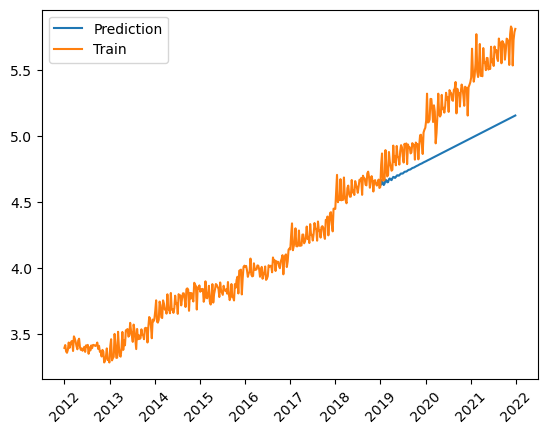

In [268]:
plt.xticks(rotation=45)
plt.plot(msft_pred,label='Prediction')
plt.plot(msft_train,label="Train")
plt.legend()

In [36]:
history = [x for x in amzn_train]
model_predictions = []
N_test_observations = len(amzn_test)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(3,1,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = amzn_test[time_point]
    history.append(true_test_value)


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
MSE_error = mean_squared_error(amzn_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 0.006090542126919773


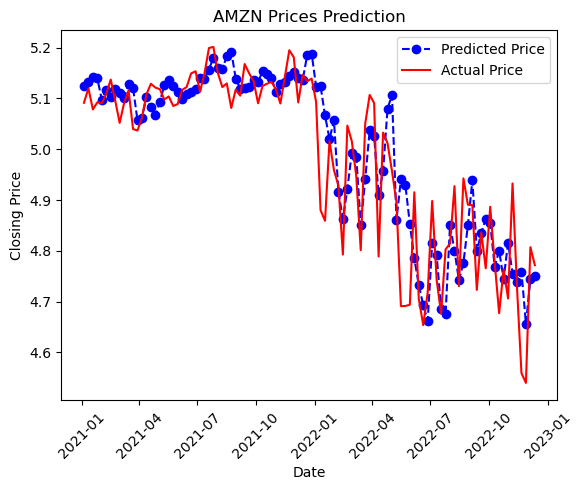

In [54]:
#test_set_range = amzn_week[int(len(amzn_week)*0.7):].index
test_set_range= amzn_test.index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, amzn_test, color='red', label='Actual Price')
plt.title('AMZN Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation = 45)
plt.legend()
plt.show()